# EffNet

A [EffNet](https://github.com/andrijdavid/EffNet) é uma estrutura de rede neural convolucional mostrada pela primeira vez em 2018, por meio de um [artigo](https://arxiv.org/abs/1801.06434) submetido ao IIIE 2018. A rede é um modelo pequeno de pouco menos de 2 milhões de parâmetros, mas que se propõe a ser eficiente para hardwares mobiles e sistemas de capacidade menor, como os embarcados.


### Importando bibliotecas

Espaço para importações. Serão utilizadas:


* **cv2** e **PIL** para a manipulação das imagens,
* **matplotlib** e **seaborn** para a visualização gráfica,
* **numpy** para operações matemáticas,
* **sklearn** para a divisão do dataset e cálculo de métricas,
* **os** para a manipulação de arquivos.
* **torch** para definição, treino e otimização da EffeNet


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Definindo constantes

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
PATH = "/kaggle/input/pumch-isd/PUMCH-ISD"

device = "cuda" if torch.cuda.is_available() else "cpu"

### Conhecendo o conjunto de dados

Ainda que o dataset original possua tanto imagens clínicas quanto dermoscópicas, foi-se escolhido treinar para com o segundo grupo de imagens, isto porque a inconstância das imagens clínicas (como a presença de faixas pretas) poderia enviesar os resultados de alguma forma.

In [3]:
image_paths = []
labels = []

class_names = sorted(os.listdir(PATH)) 
class_index = {name: idx for idx, name in enumerate(class_names)}

for disease_name in class_names:
    disease_path = os.path.join(PATH, disease_name)
    
    if os.path.isdir(disease_path):
        dermoscopy_path = os.path.join(disease_path, "dermoscopy")

        if os.path.exists(dermoscopy_path):
            for img_file in os.listdir(dermoscopy_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(dermoscopy_path, img_file)
                    image_paths.append(img_path)

                    labels.append(class_index[disease_name])

In [4]:
print(f"Doenças: {class_names}")
print(f"Qtde de imagens: {len(image_paths)}")

Doenças: ['Acne vulgaris', 'Dermatitis_subset1', 'Dermatitis_subset2', 'Lichen planus', 'Morphea', 'Pityriasis rosea', 'Psoriasis', 'Rosacea', 'Vitiligo']
Qtde de imagens: 7798


Assim,  as imagens são divididas em partições de treino, validação e teste, com seed padrão em 42 e uma partição 70/30.

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

Tendo em vista o desbalanceamento de algumas classes, é preferível treinar a rede considerando os pesos proporcionais a cada categoria de imagem. As classes de maiores pesos, que também são aquelas que possuem menos amostras, serão preferíveis no momento da classificação.

In [6]:
class_counts = np.bincount(y_train)
class_weights = 1. / (class_counts ** 0.5)
class_weights = class_weights / class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(class_weights)

tensor([0.0874, 0.0847, 0.1227, 0.1044, 0.1045, 0.1807, 0.0804, 0.0956, 0.1395],
       device='cuda:0')


No PyTorch, as imagens são carregadas a partir de datasets, que carregam tanto o caminho para as imagens, os labels (nomes das classes) e um atributo de `transform`. O transform dita certas transformações específicas para as imagens, como imagens rotacionadas (`RandomHorizontalFlip`). Assim, cada época receberá uma versão ligeiramente diferente de uma mesma imagem, garantindo certa variabilidade.

In [7]:
class SkinDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

É também pelo `transform` que as imagens são redimensionadas para o tamanho 224x224 (as originais eram muito grandes, o que dificultaria o treinamento da rede) e convertidas para um array `torch.FloatTensor` de três dimensões (Chanels, Height, Weight).

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

Depois, é separado um `SkinDataset` para cada partição de treino, validação e teste.

In [9]:
train_dataset = SkinDataset(X_train, y_train, transform=train_transform)
val_dataset   = SkinDataset(X_val, y_val, transform=test_transform)
test_dataset  = SkinDataset(X_test, y_test, transform=test_transform)

train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader    = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader   = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

### Definindo o modelo

As classes abaixo foram retiradas do [github de Andrij David](https://github.com/andrijdavid/EffNet), que propõe uma implementação para a arquitetura da EffNet mostrada no artigo.

A rede proposta é formada por três blocos convolucionais sequenciais, cada um projetado para reduzir progressivamente a resolução espacial enquanto aumenta a profundidade dos canais. Cada bloco começa com uma convolução 1×1 para ajustar o número de canais, seguida de normalização e ativação `LeakyReLU`. Em seguida, são aplicadas duas convoluções `depthwise` separáveis, cada uma acompanhada por normalização e ativação. Entre essas convoluções há uma operação de `MaxPooling`. Ao final de cada bloco, é usada uma convolução 1×2 com `stride` 2, responsável por reduzir a resolução horizontal e aumentar o número de canais (32 > 64 > 128 > 256). Após os três blocos, os mapas de ativação são achatados e alimentados em uma camada totalmente conectada que produz as probabilidades finais para as classes.

A EffNet original trabalhava com imagens pequenas de tamanho 32 x 32. Sendo aqui o IMG_SIZE = 224, uma pequena adaptação foi feita para que o modelo fosse capaz de aceitar os nossos dados de entrada, mudando a quantidade de elementos de elementos de entrada (tamanho do feature map) de 4096 para 200704.

In [10]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x
     
class EffNet(nn.Module):

    def __init__(self, nb_classes=10, include_top=True, weights=None):
        super(EffNet, self).__init__()
        
        self.block1 = self.make_layers(32, 64)
        self.block2 = self.make_layers(64, 128)
        self.block3 = self.make_layers(128, 256)
        self.flatten = Flatten()
        self.linear = nn.Linear(200704, nb_classes)
        self.include_top = include_top
        self.weights = weights

    def make_layers(self, ch_in, ch_out):
        layers = [
            nn.Conv2d(3, ch_in, kernel_size=(1,1), stride=(1,1), bias=False, padding=0, dilation=(1,1)) if ch_in ==32 else nn.Conv2d(ch_in, ch_in, kernel_size=(1,1),stride=(1,1), bias=False, padding=0, dilation=(1,1)) ,
            self.make_post(ch_in),
            
            # DepthWiseConvolution2D
            nn.Conv2d(ch_in, 1 * ch_in, groups=ch_in, kernel_size=(1, 3),stride=(1,1), padding=(0,1), bias=False, dilation=(1,1)),
            self.make_post(ch_in),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),
            
            # DepthWiseConvolution2D
            nn.Conv2d(ch_in, 1 * ch_in, groups=ch_in, kernel_size=(3, 1), stride=(1,1), padding=(1,0), bias=False, dilation=(1,1)),
            self.make_post(ch_in),
            nn.Conv2d(ch_in, ch_out, kernel_size=(1, 2), stride=(1, 2), bias=False, padding=(0,0), dilation=(1,1)),
            self.make_post(ch_out),
        ]
        return nn.Sequential(*layers)

    def make_post(self, ch_in):
        layers = [
            nn.LeakyReLU(0.3),
            nn.BatchNorm2d(ch_in, momentum=0.99)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        if self.include_top:
            x = self.flatten(x)
            x = self.linear(x)
        return x

O `summary` mostra melhor a arquitetura montada da EffNet, totalizando quase 2 milhões de parâmetros.

In [11]:
num_classes = len(class_names)

model = EffNet(nb_classes=num_classes).to(device)
summary(model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
EffNet                                   [32, 9]                   --
├─Sequential: 1-1                        [32, 64, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 32, 224, 224]        96
│    └─Sequential: 2-2                   [32, 32, 224, 224]        --
│    │    └─LeakyReLU: 3-1               [32, 32, 224, 224]        --
│    │    └─BatchNorm2d: 3-2             [32, 32, 224, 224]        64
│    └─Conv2d: 2-3                       [32, 32, 224, 224]        96
│    └─Sequential: 2-4                   [32, 32, 224, 224]        --
│    │    └─LeakyReLU: 3-3               [32, 32, 224, 224]        --
│    │    └─BatchNorm2d: 3-4             [32, 32, 224, 224]        64
│    └─MaxPool2d: 2-5                    [32, 32, 112, 224]        --
│    └─Conv2d: 2-6                       [32, 32, 112, 224]        96
│    └─Sequential: 2-7                   [32, 32, 112, 224]        --
│    │    └─Lea

O histórico (history) padrão do `keras` é simulado por meio de um dicionário que recebe as acurácias e perdas de treinamento. No `criterion`, também são passados os pesos para as classes e como otimizador, o Adam.

In [12]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Com tudo setado, inicia-se o treinamento.

In [13]:
for epoch in range(EPOCHS):
    
    # TREINO
    model.train()
    correct = 0
    total = 0
    train_loss_epoch = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc_epoch = correct / total
    history["train_loss"].append(train_loss_epoch / len(train_loader))
    history["train_acc"].append(train_acc_epoch)

    # VALIDAÇÃO
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_epoch = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss_epoch += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc_epoch = val_correct / val_total

    history["val_loss"].append(val_loss_epoch / len(val_loader))
    history["val_acc"].append(val_acc_epoch)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"train_loss={history['train_loss'][-1]:.4f}, "
          f"val_loss={history['val_loss'][-1]:.4f}, "
          f"train_acc={train_acc_epoch:.4f}, "
          f"val_acc={val_acc_epoch:.4f}")

Epoch 1/15 | train_loss=2.0089, val_loss=1.8414, train_acc=0.3910, val_acc=0.4530
Epoch 2/15 | train_loss=1.0194, val_loss=1.9797, train_acc=0.6931, val_acc=0.4368
Epoch 3/15 | train_loss=0.5685, val_loss=1.8043, train_acc=0.8292, val_acc=0.4162
Epoch 4/15 | train_loss=0.3045, val_loss=1.8087, train_acc=0.9165, val_acc=0.4897
Epoch 5/15 | train_loss=0.1614, val_loss=1.7963, train_acc=0.9571, val_acc=0.4983
Epoch 6/15 | train_loss=0.1016, val_loss=1.9567, train_acc=0.9714, val_acc=0.4906
Epoch 7/15 | train_loss=0.0594, val_loss=1.7488, train_acc=0.9863, val_acc=0.4641
Epoch 8/15 | train_loss=0.0386, val_loss=1.8230, train_acc=0.9916, val_acc=0.5120
Epoch 9/15 | train_loss=0.0241, val_loss=1.9361, train_acc=0.9956, val_acc=0.5145
Epoch 10/15 | train_loss=0.0183, val_loss=1.9432, train_acc=0.9969, val_acc=0.5137
Epoch 11/15 | train_loss=0.0119, val_loss=2.0156, train_acc=0.9989, val_acc=0.5171
Epoch 12/15 | train_loss=0.0070, val_loss=1.8417, train_acc=0.9993, val_acc=0.5316
Epoch 13/15 |

As predições são guardadas para o cálculo das métricas de avaliação.

In [14]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.numpy())

### Conferindo o desempenho do modelo

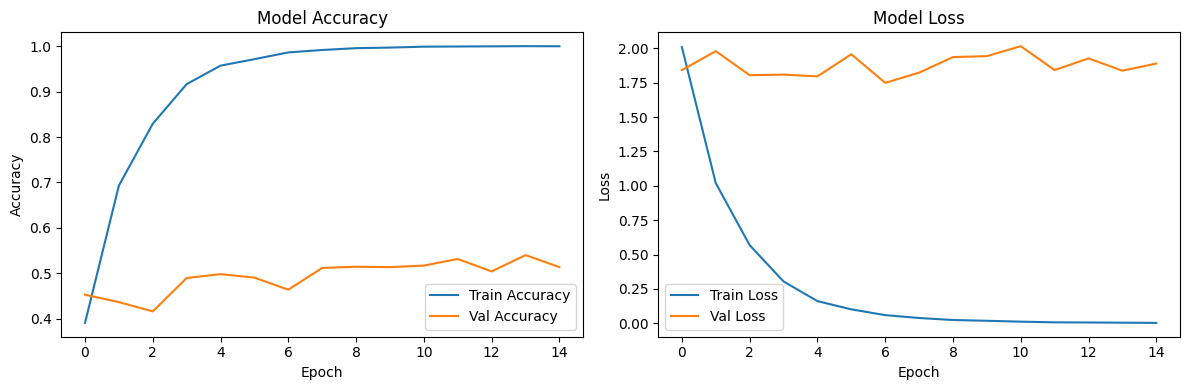

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history["train_acc"], label="Train Accuracy")
ax1.plot(history["val_acc"], label="Val Accuracy")
ax1.set_title("Model Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.legend()

ax2.plot(history["train_loss"], label="Train Loss")
ax2.plot(history["val_loss"], label="Val Loss")
ax2.set_title("Model Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()

plt.tight_layout()
plt.show()

As métricas de avaliação utilizadas serão precisão, recall, f1-score e acurácia para cada uma das classes preditas.

                    precision    recall  f1-score   support

     Acne vulgaris       0.52      0.76      0.62       177
Dermatitis_subset1       0.48      0.50      0.49       189
Dermatitis_subset2       0.26      0.22      0.24        90
     Lichen planus       0.54      0.57      0.55       124
           Morphea       0.49      0.59      0.53       123
  Pityriasis rosea       0.67      0.24      0.36        41
         Psoriasis       0.60      0.41      0.49       209
           Rosacea       0.70      0.64      0.67       148
          Vitiligo       0.60      0.54      0.56        69

          accuracy                           0.53      1170
         macro avg       0.54      0.50      0.50      1170
      weighted avg       0.54      0.53      0.52      1170



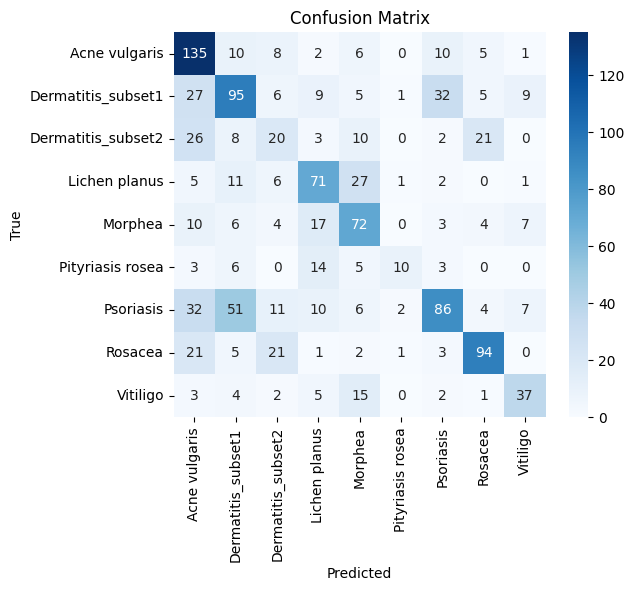

In [16]:
print(classification_report(
    y_true, 
    y_pred, 
    target_names=class_names,
    zero_division=0
))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Como a acurácia não é uma métrica padrão imprimida no classification report para casos multiclasse, ela deve ser calculada separadamente pela fórmula: 
$$
\text{Acurácia} = \frac{\text{Número de predições corretas}}{\text{Número total de amostras}}
$$

In [17]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)

for cls, acc in zip(class_names, class_accuracy):
    print(f"{cls}: {acc:.4f}")

Acne vulgaris: 0.7627
Dermatitis_subset1: 0.5026
Dermatitis_subset2: 0.2222
Lichen planus: 0.5726
Morphea: 0.5854
Pityriasis rosea: 0.2439
Psoriasis: 0.4115
Rosacea: 0.6351
Vitiligo: 0.5362
